In [17]:
print("hello world")

hello world


In [76]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


import torch
from torch.utils.data import Dataset
import random
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms

In [79]:

class SegmentationTransforms:
    def __init__(self, image_size=(256, 256), degrees=15, scale=(0.8, 1.2), shear=10, contrast_range=(0.5, 1.0)):
        self.image_size = image_size
        self.degrees = degrees
        self.scale = scale
        self.shear = shear
        self.contrast_range = contrast_range  # new param for contrast factor range

    def __call__(self, image, mask):
        # Horizontal flip
        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        # Vertical flip
        if random.random() > 0.5:
            image = TF.vflip(image)
            mask = TF.vflip(mask)

        # Random affine transform
        angle = random.uniform(-self.degrees, self.degrees)
        translations = (0, 0)
        scale = random.uniform(self.scale[0], self.scale[1])
        shear = random.uniform(-self.shear, self.shear)
        image = TF.affine(image, angle=angle, translate=translations, scale=scale, shear=shear, fill=0)
        mask = TF.affine(mask, angle=angle, translate=translations, scale=scale, shear=shear, fill=0, interpolation=TF.InterpolationMode.NEAREST)

        # Random crop
        i, j, h, w = transforms.RandomCrop.get_params(image, output_size=self.image_size)
        image = TF.crop(image, i, j, h, w)
        mask = TF.crop(mask, i, j, h, w)

        # Color jitter on image
        color_jitter = transforms.ColorJitter(0.2, 0.2, 0.2, 0.05)
        image = color_jitter(image)

        # Random contrast adjustment (factor between contrast_range)
        contrast_factor = random.uniform(self.contrast_range[0], self.contrast_range[1])
        image = TF.adjust_contrast(image, contrast_factor)

        # Optional: Gaussian blur on image only
        if random.random() > 0.7:
            image = TF.gaussian_blur(image, kernel_size=3)

        # Resize both to image_size
        image = TF.resize(image, self.image_size)
        mask = TF.resize(mask, self.image_size, interpolation=TF.InterpolationMode.NEAREST)

        return image, mask

In [80]:
# Instantiate transform
augmentor = SegmentationTransforms(image_size=(256, 256))

#Paths
image_path = "src\dataset\images\Grain 1.png"
mask_path = "src\dataset\masks\Grain 1.png"

# Load your image and mask (both must be PIL Images)
image = Image.open(image_path).convert('L')
mask = Image.open(mask_path).convert('L')

# Instantiate and apply transform
augmentor = SegmentationTransforms(image_size=(256, 256))
aug_image, aug_mask = augmentor(image, mask)

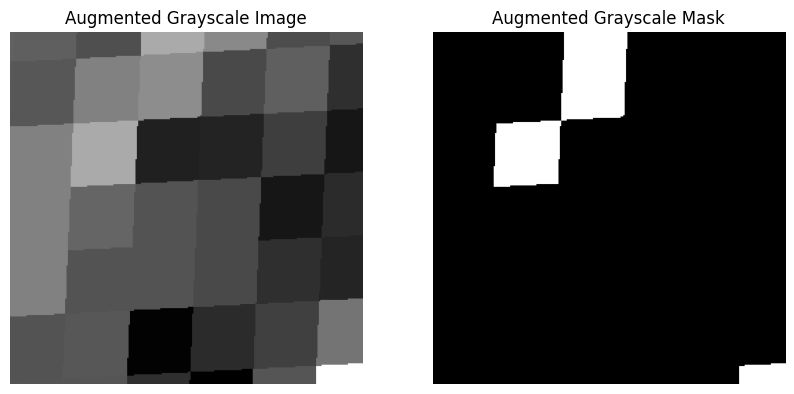

In [81]:
# Show results
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].imshow(aug_image, cmap='gray')
ax[0].set_title('Augmented Grayscale Image')
ax[0].axis('off')

ax[1].imshow(aug_mask, cmap='gray')
ax[1].set_title('Augmented Grayscale Mask')
ax[1].axis('off')

plt.show()

In [82]:
def augment_dataset(src_img_dir, src_mask_dir, dst_img_dir, dst_mask_dir, augmentor, augmentations_per_image=5):
    os.makedirs(dst_img_dir, exist_ok=True)
    os.makedirs(dst_mask_dir, exist_ok=True)

    img_filenames = [f for f in os.listdir(src_img_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]

    for img_name in img_filenames:
        img_path = os.path.join(src_img_dir, img_name)
        mask_path = os.path.join(src_mask_dir, img_name)  # assuming masks have same filename

        if not os.path.exists(mask_path):
            print(f"Mask for image {img_name} not found, skipping.")
            continue

        image = Image.open(img_path).convert('L')
        mask = Image.open(mask_path).convert('L')

        for i in range(augmentations_per_image):
            aug_image, aug_mask = augmentor(image, mask)

            base_name, ext = os.path.splitext(img_name)
            aug_img_name = f"{base_name}_aug_{i+1}{ext}"

            aug_image.save(os.path.join(dst_img_dir, aug_img_name))
            aug_mask.save(os.path.join(dst_mask_dir, aug_img_name))

        print(f"Augmented {img_name} with {augmentations_per_image} samples.")

In [83]:
src_images = "src/dataset/images"
src_masks = "src/dataset/masks"
dst_images = "src/dataset_aug/images"
dst_masks = "src/dataset_aug/masks"
augmentations_per_image = 5  # adjust this as you want

augmentor = SegmentationTransforms(image_size=(256, 256))
augment_dataset(src_images, src_masks, dst_images, dst_masks, augmentor, augmentations_per_image)

Augmented Grain 1.png with 5 samples.
Augmented Grain 102.png with 5 samples.
Mask for image Grain 106.png not found, skipping.
Augmented Grain 114.png with 5 samples.
Augmented Grain 13.png with 5 samples.
Augmented Grain 17.png with 5 samples.
Augmented Grain 18.png with 5 samples.
Augmented Grain 2.png with 5 samples.
Augmented Grain 25.png with 5 samples.
Augmented Grain 3.png with 5 samples.
Augmented Grain 33.png with 5 samples.
Augmented Grain 35.png with 5 samples.
Augmented Grain 5.png with 5 samples.
Augmented Grain 6.png with 5 samples.
Augmented Grain 7.png with 5 samples.
Augmented Grain 76.png with 5 samples.
Augmented Grain 78.png with 5 samples.
Augmented Grain 79.png with 5 samples.
Augmented Grain 8.png with 5 samples.


In [88]:
import torchvision.models.segmentation as segmentation

model = segmentation.deeplabv3_resnet101(pretrained=True)
model.eval()

c:\Users\lpwil\Documents\Portfolio Projects\RadonAngleFinder\.venv\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
c:\Users\lpwil\Documents\Portfolio Projects\RadonAngleFinder\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to C:\Users\lpwil/.cache\torch\hub\checkpoints\deeplabv3_resnet101_coco-586e9e4e.pt

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [110]:
img_path = "src/dataset/images/Grain 1.png"
image = Image.open(img_path).convert("RGB")

# Run inference
input_tensor = input_transform(image).unsqueeze(0)
model.eval()
with torch.no_grad():
    output = model(input_tensor)['out'][0]

# Get predicted classes per pixel
pred_classes = output.argmax(0).byte().cpu()

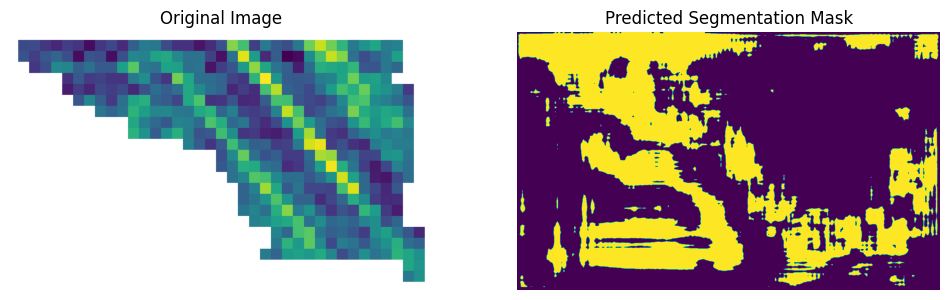

In [111]:
# Visualize predicted segmentation mask
plt.figure(figsize=(12, 6))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(image)  # image is your PIL RGB image
plt.title("Original Image")
plt.axis('off')

# Predicted segmentation mask
plt.subplot(1, 2, 2)
plt.imshow(pred_classes)
plt.title("Predicted Segmentation Mask")
plt.axis('off')

plt.show()

In [98]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, target_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_filenames = os.listdir(image_dir)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        image = Image.open(os.path.join(self.image_dir, img_name)).convert("RGB")
        mask = Image.open(os.path.join(self.mask_dir, img_name)).convert("L")

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            mask = self.target_transform(mask)

        return image, mask

In [99]:
# Define the transformation pipeline for input images (e.g., RGB photos)
input_transform = transforms.Compose([
    transforms.ToTensor(),  # Converts the PIL image to a PyTorch tensor and scales pixel values to [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalization values typically used for ImageNet-trained models
                         std=[0.229, 0.224, 0.225])   # Helps the model generalize better by standardizing inputs
])


# Define the transformation pipeline for segmentation masks (e.g., grayscale label maps)
mask_transform = transforms.Compose([
    transforms.PILToTensor(),  # Converts PIL image to tensor without scaling pixel values
    transforms.Lambda(lambda x: x.squeeze().long())  # Removes channel dimension (if present) and converts to long type (for class labels)
])

In [103]:
import torch
from torch.utils.data import DataLoader
import torch.optim as optim

num_classes = 2
model.classifier[4] = torch.nn.Conv2d(256, num_classes, kernel_size=1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

train_dataset = SegmentationDataset("src/dataset_aug/images", "src/dataset_aug/masks", input_transform, mask_transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss(ignore_index=255)

In [104]:
epochs=1
model.train()
for epoch in range(epochs):
    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)

        optimizer.zero_grad()
        output = model(imgs)['out']
        loss = criterion(output, masks)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}")

Epoch 1: Loss = 0.5779
